## Transcrire un algorithme (Grover)

### Registres

In [8]:
from qiskit import QuantumRegister, ClassicalRegister

valeurs = QuantumRegister(3, 'valeurs')
mesures = ClassicalRegister(valeurs.size, 'mesures')

### Oracle

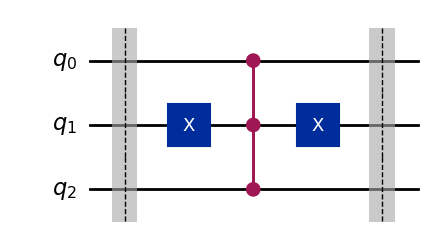

In [9]:
from qiskit import QuantumCircuit

oracle = QuantumCircuit(valeurs.size)
oracle.barrier(range(oracle.num_qubits))
oracle.x(1)
oracle.ccz(0, 1, 2)
oracle.x(1)
oracle.barrier(range(oracle.num_qubits))
oracle.draw('mpl')

### Diffuseur

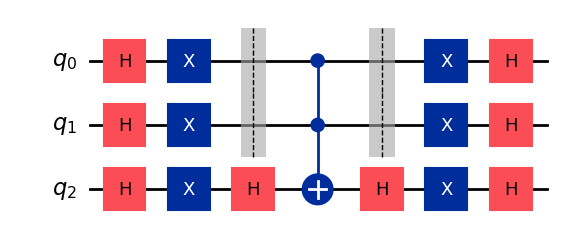

In [10]:
diffuseur = QuantumCircuit(valeurs.size)
diffuseur.h(range(diffuseur.num_qubits))
diffuseur.x(range(diffuseur.num_qubits))
diffuseur.barrier(range(diffuseur.num_qubits-1))
diffuseur.h(diffuseur.num_qubits-1)
diffuseur.ccx(0, 1, 2)
diffuseur.h(diffuseur.num_qubits-1)
diffuseur.barrier(range(diffuseur.num_qubits-1))
diffuseur.x(range(diffuseur.num_qubits))
diffuseur.h(range(diffuseur.num_qubits))
diffuseur.draw('mpl')

### Circuit

#### Amorce
Portes d'Hadamard + Oracle

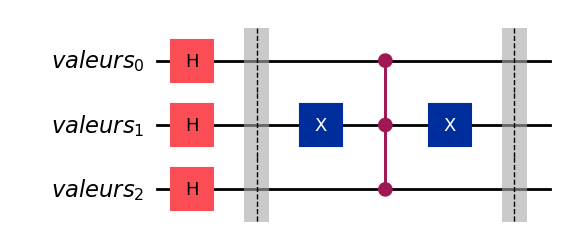

In [17]:
circuit = QuantumCircuit(valeurs)
circuit.h(range(circuit.num_qubits))
circuit = circuit.compose(oracle)
circuit.draw('mpl')

#### Vérification de l'oracle
Simulation partielle

In [12]:
from qiskit import transpile
from qiskit_aer import Aer

simulator = Aer.get_backend('statevector_simulator')
result = simulator.run(transpile(circuit, simulator), shots=256).result()
states = result.get_statevector(circuit)
states


Statevector([ 0.35355339+0.00000000e+00j,  0.35355339-4.32978028e-17j,
              0.35355339+0.00000000e+00j,  0.35355339+0.00000000e+00j,
              0.35355339-4.32978028e-17j, -0.35355339+8.65956056e-17j,
              0.35355339-4.32978028e-17j,  0.35355339-4.32978028e-17j],
            dims=(2, 2, 2))


Phases

In [13]:
from numpy import arctan2, degrees, round

[round(degrees(arctan2(state.imag, state.real))) for state in states]

/tmp/ipykernel_1598/2097038049.py:3: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  [round(degrees(arctan2(state.imag, state.real))) for state in states]


[0.0, -0.0, 0.0, 0.0, -0.0, 180.0, -0.0, -0.0]

Graphique

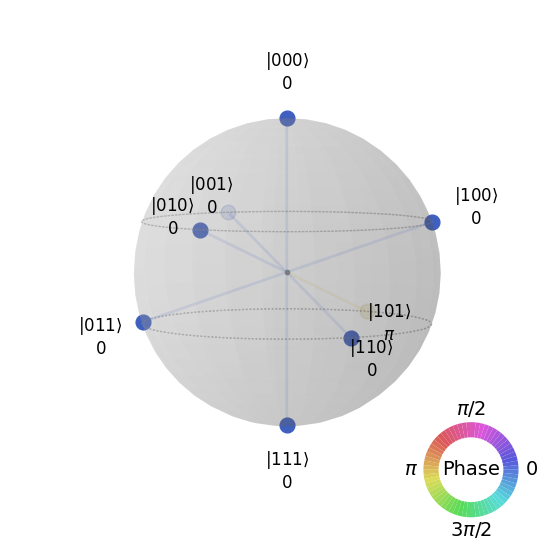

In [14]:
from qiskit.visualization import plot_state_qsphere

plot_state_qsphere(states, show_state_phases=True)

#### Ajout du diffuseur

In [18]:
circuit.compose(diffuseur, inplace=True)
circuit.draw()

┌───┐ ░               ░ ┌───┐┌───┐  ░         ░  ┌───┐┌───┐
valeurs_0: ┤ H ├─░───────■───────░─┤ H ├┤ X ├──░────■────░──┤ X ├┤ H ├
           ├───┤ ░ ┌───┐ │ ┌───┐ ░ ├───┤├───┤  ░    │    ░  ├───┤├───┤
valeurs_1: ┤ H ├─░─┤ X ├─■─┤ X ├─░─┤ H ├┤ X ├──░────■────░──┤ X ├┤ H ├
           ├───┤ ░ └───┘ │ └───┘ ░ ├───┤├───┤┌───┐┌─┴─┐┌───┐├───┤├───┤
valeurs_2: ┤ H ├─░───────■───────░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
           └───┘ ░               ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘

#### Répétition + Mesure

In [19]:
circuit = circuit \
    .compose(oracle) \
    .compose(diffuseur)

circuit.add_register(mesures)
circuit.measure_all(add_bits=False)
circuit.draw()

┌───┐ ░               ░ ┌───┐┌───┐  ░         ░  ┌───┐┌───┐ ░      »
valeurs_0: ┤ H ├─░───────■───────░─┤ H ├┤ X ├──░────■────░──┤ X ├┤ H ├─░──────»
           ├───┤ ░ ┌───┐ │ ┌───┐ ░ ├───┤├───┤  ░    │    ░  ├───┤├───┤ ░ ┌───┐»
valeurs_1: ┤ H ├─░─┤ X ├─■─┤ X ├─░─┤ H ├┤ X ├──░────■────░──┤ X ├┤ H ├─░─┤ X ├»
           ├───┤ ░ └───┘ │ └───┘ ░ ├───┤├───┤┌───┐┌─┴─┐┌───┐├───┤├───┤ ░ └───┘»
valeurs_2: ┤ H ├─░───────■───────░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░──────»
           └───┘ ░               ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░      »
mesures: 3/═══════════════════════════════════════════════════════════════════»
                                                                              »
«                    ░ ┌───┐┌───┐  ░         ░  ┌───┐┌───┐ ░ ┌─┐      
«valeurs_0: ─■───────░─┤ H ├┤ X ├──░────■────░──┤ X ├┤ H ├─░─┤M├──────
«            │ ┌───┐ ░ ├───┤├───┤  ░    │    ░  ├───┤├───┤ ░ └╥┘┌─┐   
«valeurs_1: ─■─┤ X ├─░─┤ H ├┤ X ├──░────■────░──┤ X ├┤ H ├─░──╫─┤M├───
«            │ └───┘ ░ ├───┤├───┤┌───┐┌─┴─┐┌───┐├───┤├───┤ ░  ║ └╥┘┌─┐
«valeurs_2: ─■───────░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░──╫──╫─┤M├
«                    ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░  ║  ║ └╥┘
«mesures: 3/══════════════════════════════════════════════════╩══╩══╩═
«                                                             0  1  2

### Simulation

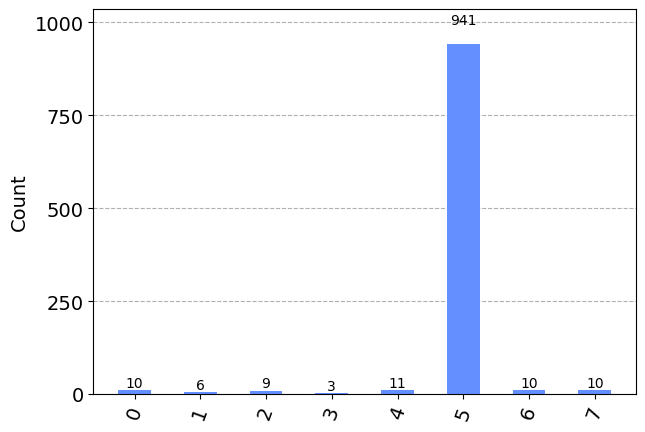

In [20]:
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

simulator = Aer.get_backend('qasm_simulator')
compiled = transpile(circuit, simulator)
job = simulator.run(compiled, shots=1000)
result = job.result()

counts = result.get_counts(compiled).int_outcomes()
plot_histogram(counts)